In [1]:
import tensorflow as tf
import numpy as np
import os

NUM_PARALLEL = 6
SEED = 42

tf.random.set_seed(SEED)
np.random.seed(SEED)

os.environ['TF_NUM_INTEROP_THREADS'] = str(NUM_PARALLEL)
os.environ['TF_NUM_INTRAOP_THREADS'] = str(NUM_PARALLEL)

In [2]:
import tensorflow_datasets as tfds
train_val, test = tfds.load('rock_paper_scissors', split=['train', 'test'], as_supervised=True)

shuffled = train_val.shuffle(10000, seed=42)
train = shuffled.take(2000)
val = shuffled.skip(2000)

2025-11-12 09:45:55.619190: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-11-12 09:45:56.516339: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


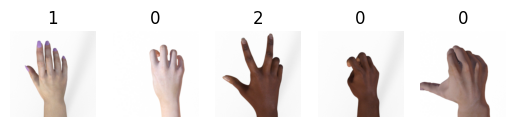

In [3]:
import matplotlib.pyplot as plt
for i, (image, label) in enumerate(train.take(5)):
    plt.subplot(1, 5, i+1)
    plt.imshow(tf.squeeze(image))
    plt.title(label.numpy())
    plt.axis('off')
plt.show()

In [4]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2)
])

def preprocess(image, label):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [64, 64])
    image = tf.image.per_image_standardization(image)
    return image, label

train = (
    train
    .map(preprocess, num_parallel_calls=NUM_PARALLEL)
    .map(lambda x, y: (data_augmentation(x), y), num_parallel_calls=NUM_PARALLEL)
    .shuffle(1000)
    .batch(32)
    .prefetch(NUM_PARALLEL)
)

val = (
    val
    .map(preprocess, num_parallel_calls=NUM_PARALLEL)
    .batch(32)
    .prefetch(NUM_PARALLEL)
)

test = (
    test
    .map(preprocess, num_parallel_calls=NUM_PARALLEL)
    .batch(32)
    .prefetch(NUM_PARALLEL)
)

2025-11-12 09:45:56.924888: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


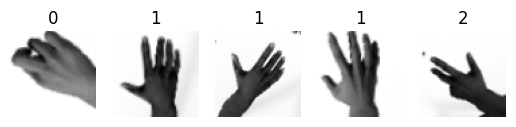

In [5]:
for i, (images, labels) in enumerate(train.take(5)):
    img = images[0]
    label = labels[0]
    
    plt.subplot(1, 5, i+1)
    plt.imshow(tf.squeeze(img), cmap='gray')
    plt.title(label.numpy())
    plt.axis('off')
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

model = tf.keras.Sequential([
    tf.keras.Input(shape=(64, 64, 1)),
    tf.keras.layers.Conv2D(128, (5, 5), activation='relu'), # 128 filtros de 5x5
    tf.keras.layers.MaxPooling2D((2, 2)),                   # Capa de pooling
    tf.keras.layers.Dropout(0.25),                          # Apagado aleatorio de neuronas
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # 64 filtros de 3x3
    tf.keras.layers.MaxPooling2D((2, 2)),                   # Capa de pooling
    tf.keras.layers.Dropout(0.25),                          # Apagado aleatorio de neuronas
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),  # 64 filtros de 3x3 
    tf.keras.layers.MaxPooling2D((2, 2)),                   # Capa de pooling
    tf.keras.layers.Dropout(0.25),                          # Apagado aleatorio de neuronas
    tf.keras.layers.Flatten(),                              # 2D -> 1D
    tf.keras.layers.Dense(50, activation='relu'),           # Capa densa oculta
    tf.keras.layers.Dropout(0.5),                           # Apagado aleatorio de neuronas
    tf.keras.layers.Dense(3, activation='softmax')          # 3 clases de salida
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(train, epochs=50, validation_data=val, callbacks=[early_stopping])

Epoch 1/50


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 84ms/step - accuracy: 0.4375 - loss: 1.0492 - val_accuracy: 0.6538 - val_loss: 0.7532
Epoch 2/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 78ms/step - accuracy: 0.6705 - loss: 0.7421 - val_accuracy: 0.8135 - val_loss: 0.3953
Epoch 3/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.7825 - loss: 0.4846 - val_accuracy: 0.9577 - val_loss: 0.1963
Epoch 4/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8440 - loss: 0.3704 - val_accuracy: 0.9962 - val_loss: 0.0448
Epoch 5/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 0.8675 - loss: 0.3193 - val_accuracy: 0.9788 - val_loss: 0.0621
Epoch 6/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - accuracy: 0.9065 - loss: 0.2297 - val_accuracy: 0.9827 - val_loss: 0.0511
Epoch 7/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.9265 - loss: 0.2119 - val_accuracy: 0.9904 - val_loss: 0.0304
Epoch 8/50
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.9300 - loss: 0.1917 - val_accuracy: 0.9788 - val_loss: 0.

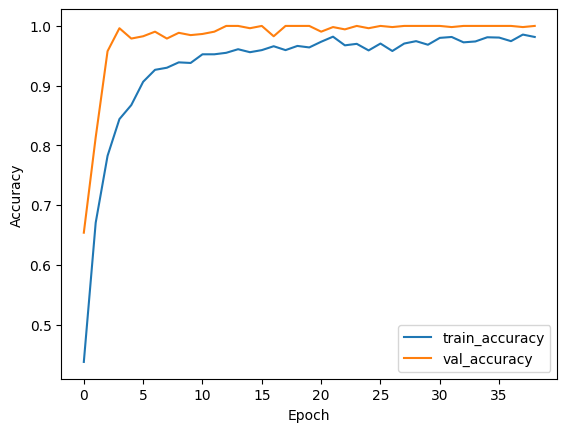

In [7]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

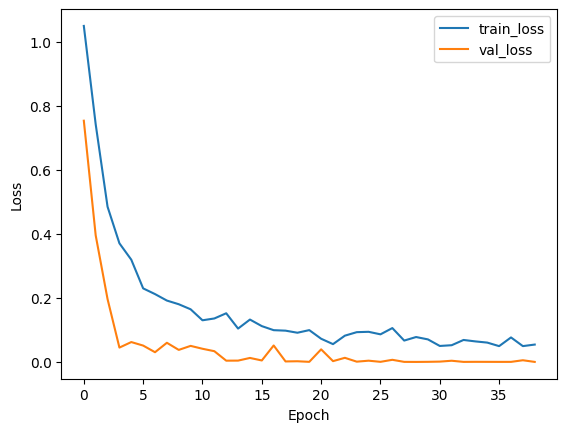

In [8]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [9]:
model.evaluate(test, return_dict=True)
# model.save('data/model.keras')

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9624 - loss: 0.1107


{'accuracy': 0.9623655676841736, 'loss': 0.11072956770658493}

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


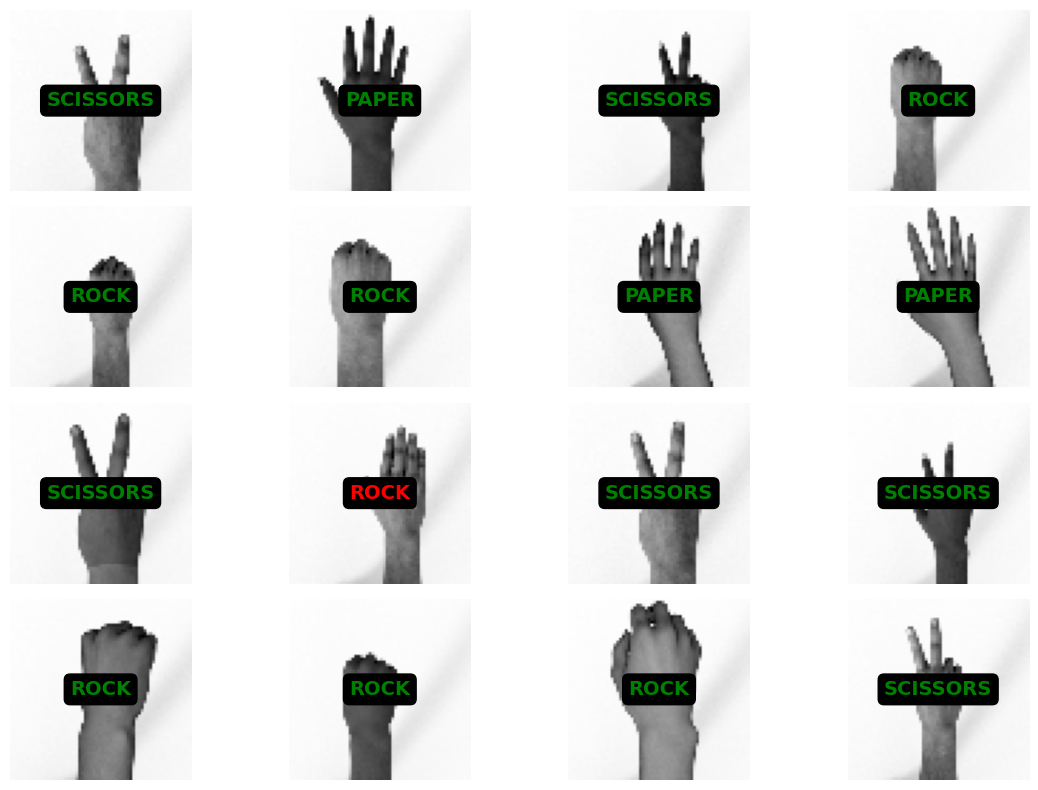

In [10]:
class_names = ['rock', 'paper', 'scissors']

for images, labels in test.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(12, 8))
    for i in range(min(len(images), 16)):
        plt.subplot(4, 4, i + 1)
        plt.imshow(tf.squeeze(images[i]), cmap='gray')
        true = class_names[labels[i]]
        pred = class_names[pred_labels[i]]
        color = "green" if true == pred else "red"
        plt.text(
                0.5, 0.5, 
                pred.upper(),
                color=color,
                fontsize=14,
                fontweight='bold',
                ha='center', va='center',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='black', boxstyle='round,pad=0.3')
            )
        plt.axis("off")
    plt.tight_layout()
    plt.show()

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

class_names = ["rock", "paper", "scissors"]
output_pdf = "data/predictions.pdf"

with PdfPages(output_pdf) as pdf:
    for batch_i, (images, labels) in enumerate(test.take(10)):
        preds = model.predict(images)
        pred_labels = np.argmax(preds, axis=1)

        rows = int(np.ceil(len(images) / 4))
        plt.figure(figsize=(12, 3 * rows))

        for i in range(len(images)):
            plt.subplot(rows, 4, i + 1)
            plt.imshow(tf.squeeze(images[i]), cmap="gray")
            true = class_names[int(labels[i])]
            pred = class_names[int(pred_labels[i])]
            color = "green" if true == pred else "red"
            plt.text(
                0.5, 0.5, 
                pred.upper(),
                color=color,
                fontsize=14,
                fontweight='bold',
                ha='center', va='center',
                transform=plt.gca().transAxes,
                bbox=dict(facecolor='black', boxstyle='round,pad=0.3')
            )
            plt.axis("off")

        plt.tight_layout()
        pdf.savefig()
        plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


2025-11-12 09:49:11.179390: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


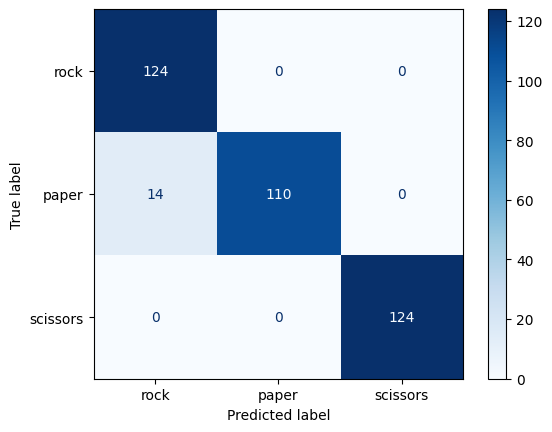

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

cm = confusion_matrix(y_true, y_pred)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names).plot(cmap=plt.cm.Blues)
plt.show()